In [1]:
from graphviz import Digraph
from autogard.data_structure import Value
import math

In [2]:

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes,edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

In [3]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right 
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label = "{data %.4f }" % (n.data, ), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [4]:
a = Value(4.0,label='a')
b = Value(-1.0,label='b')
c = Value(16.0,label='c')
d = a*b + c; d.label = 'd'

My computer is MacOS M1. 

We still need to `brew install graphviz` in shell before we run this cell

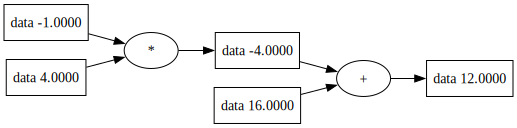

In [5]:
draw_dot(d)

In [6]:
def draw_dot(root, format='svg', rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        #modified label definition
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

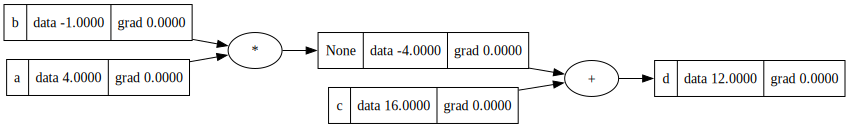

In [7]:
draw_dot(d)

In [8]:
# inputs x1,x2
x1 = Value(2.0); x1.label='x1'
x2 = Value(0.0); x2.label='x2'
# weights w1,w2 (synaptic strengths)
w1 = Value(-3.0); w1.label='w1'
w2 = Value(1.0); w2.label='w2'
# bias
b = Value(7.0); b.label='b'
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'


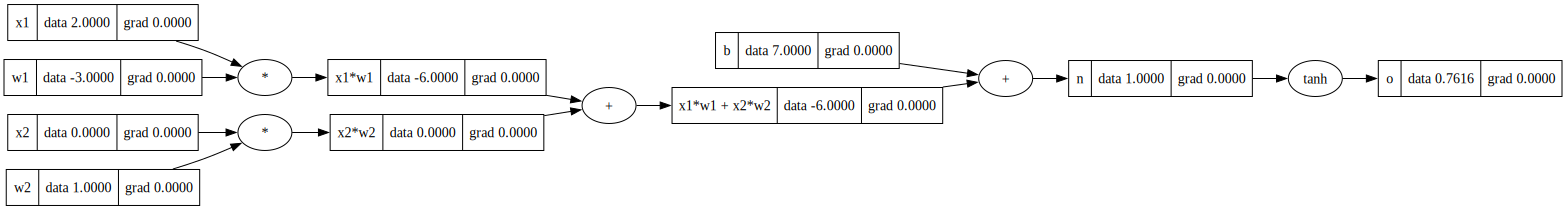

In [9]:
draw_dot(o)

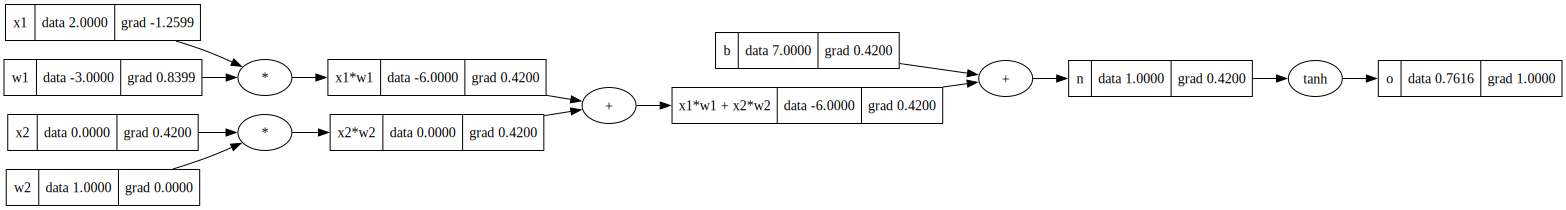

In [10]:
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

draw_dot(o)

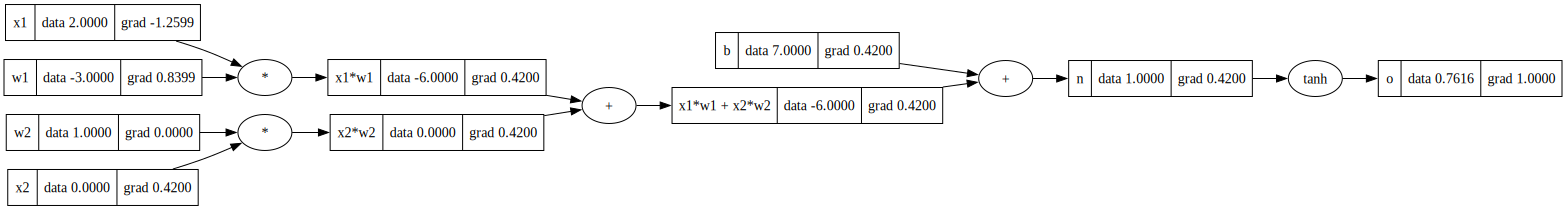

In [11]:
#Forward Pass
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(7, label='b')
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

#Backward Pass
o.backward()

#Graph
draw_dot(o)

In [12]:
print(x1.grad)

-1.2599230248420783


In [13]:
import torch
import time

In [14]:
# Forward pass
t_x1 = torch.tensor(2.0, requires_grad=True)
t_x2 = torch.tensor(0.0, requires_grad=True)
t_w1 = torch.tensor(-3.0, requires_grad=True)
t_w2 = torch.tensor(1.0, requires_grad=True)
t_b = torch.tensor(7.0, requires_grad=True)

t_x1w1 = t_x1 * t_w1
t_x2w2 = t_x2 * t_w2
t_x1w1x2w2 = t_x1w1 + t_x2w2
t_n = t_x1w1x2w2 + t_b
t_o = torch.tanh(t_n)

# Backward pass
start_time = time.time()
t_o.backward()
end_time = time.time()
torch_backward_duration = end_time - start_time
print(f"Pytorch backward pass took {torch_backward_duration:.6f} seconds")

#Forward Pass
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(7, label='b')
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

#Backward Pass
start_time = time.time()
o.backward()
end_time = time.time()
my_backward_duration = end_time - start_time
print(f"My backward pass took {my_backward_duration:.6f} seconds")

Pytorch backward pass took 0.053786 seconds
My backward pass took 0.000024 seconds


In [15]:
from torchviz import make_dot

# Visualize the graph
dot = make_dot(t_o, params={'t_x1': t_x1, 't_x2': t_x2, 't_w1': t_w1, 't_w2': t_w2, 't_b': t_b})
dot.render('torch_computation_graph', format='png')  # This will save the graph as a PNG image

'torch_computation_graph.png'